In [1]:
import csv
import string
from tqdm import tqdm
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
import pymorphy2
import fasttext
from sklearn.model_selection import ParameterGrid

In [2]:
category_tree = pd.read_csv('Data/categories_tree.csv')
train_df = pd.read_parquet('Data/train.parquet')
test_df = pd.read_parquet('Data/test.parquet')

In [3]:
category_tree.head()

,id,title,parent_id
0,1,Все категории,0
1,114,Урбеч,1913
2,115,Варенье и джемы,328
3,128,Сухие завтраки,2475
4,131,Масла,2475


In [4]:
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370 entries, 0 to 3369
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3370 non-null   int64 
 1   title      3370 non-null   object
 2   parent_id  3370 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 79.1+ KB


In [5]:
category_tree.sort_values(by='id', inplace=True)

Для визуализации и отслеживания всех связей нашего каталога используем библиотеку networkx.

In [6]:
category_graph = nx.DiGraph()
category_graph.add_edges_from(category_tree[['parent_id', 'id']].values)

In [7]:
pos = nx.kamada_kawai_layout(category_graph)

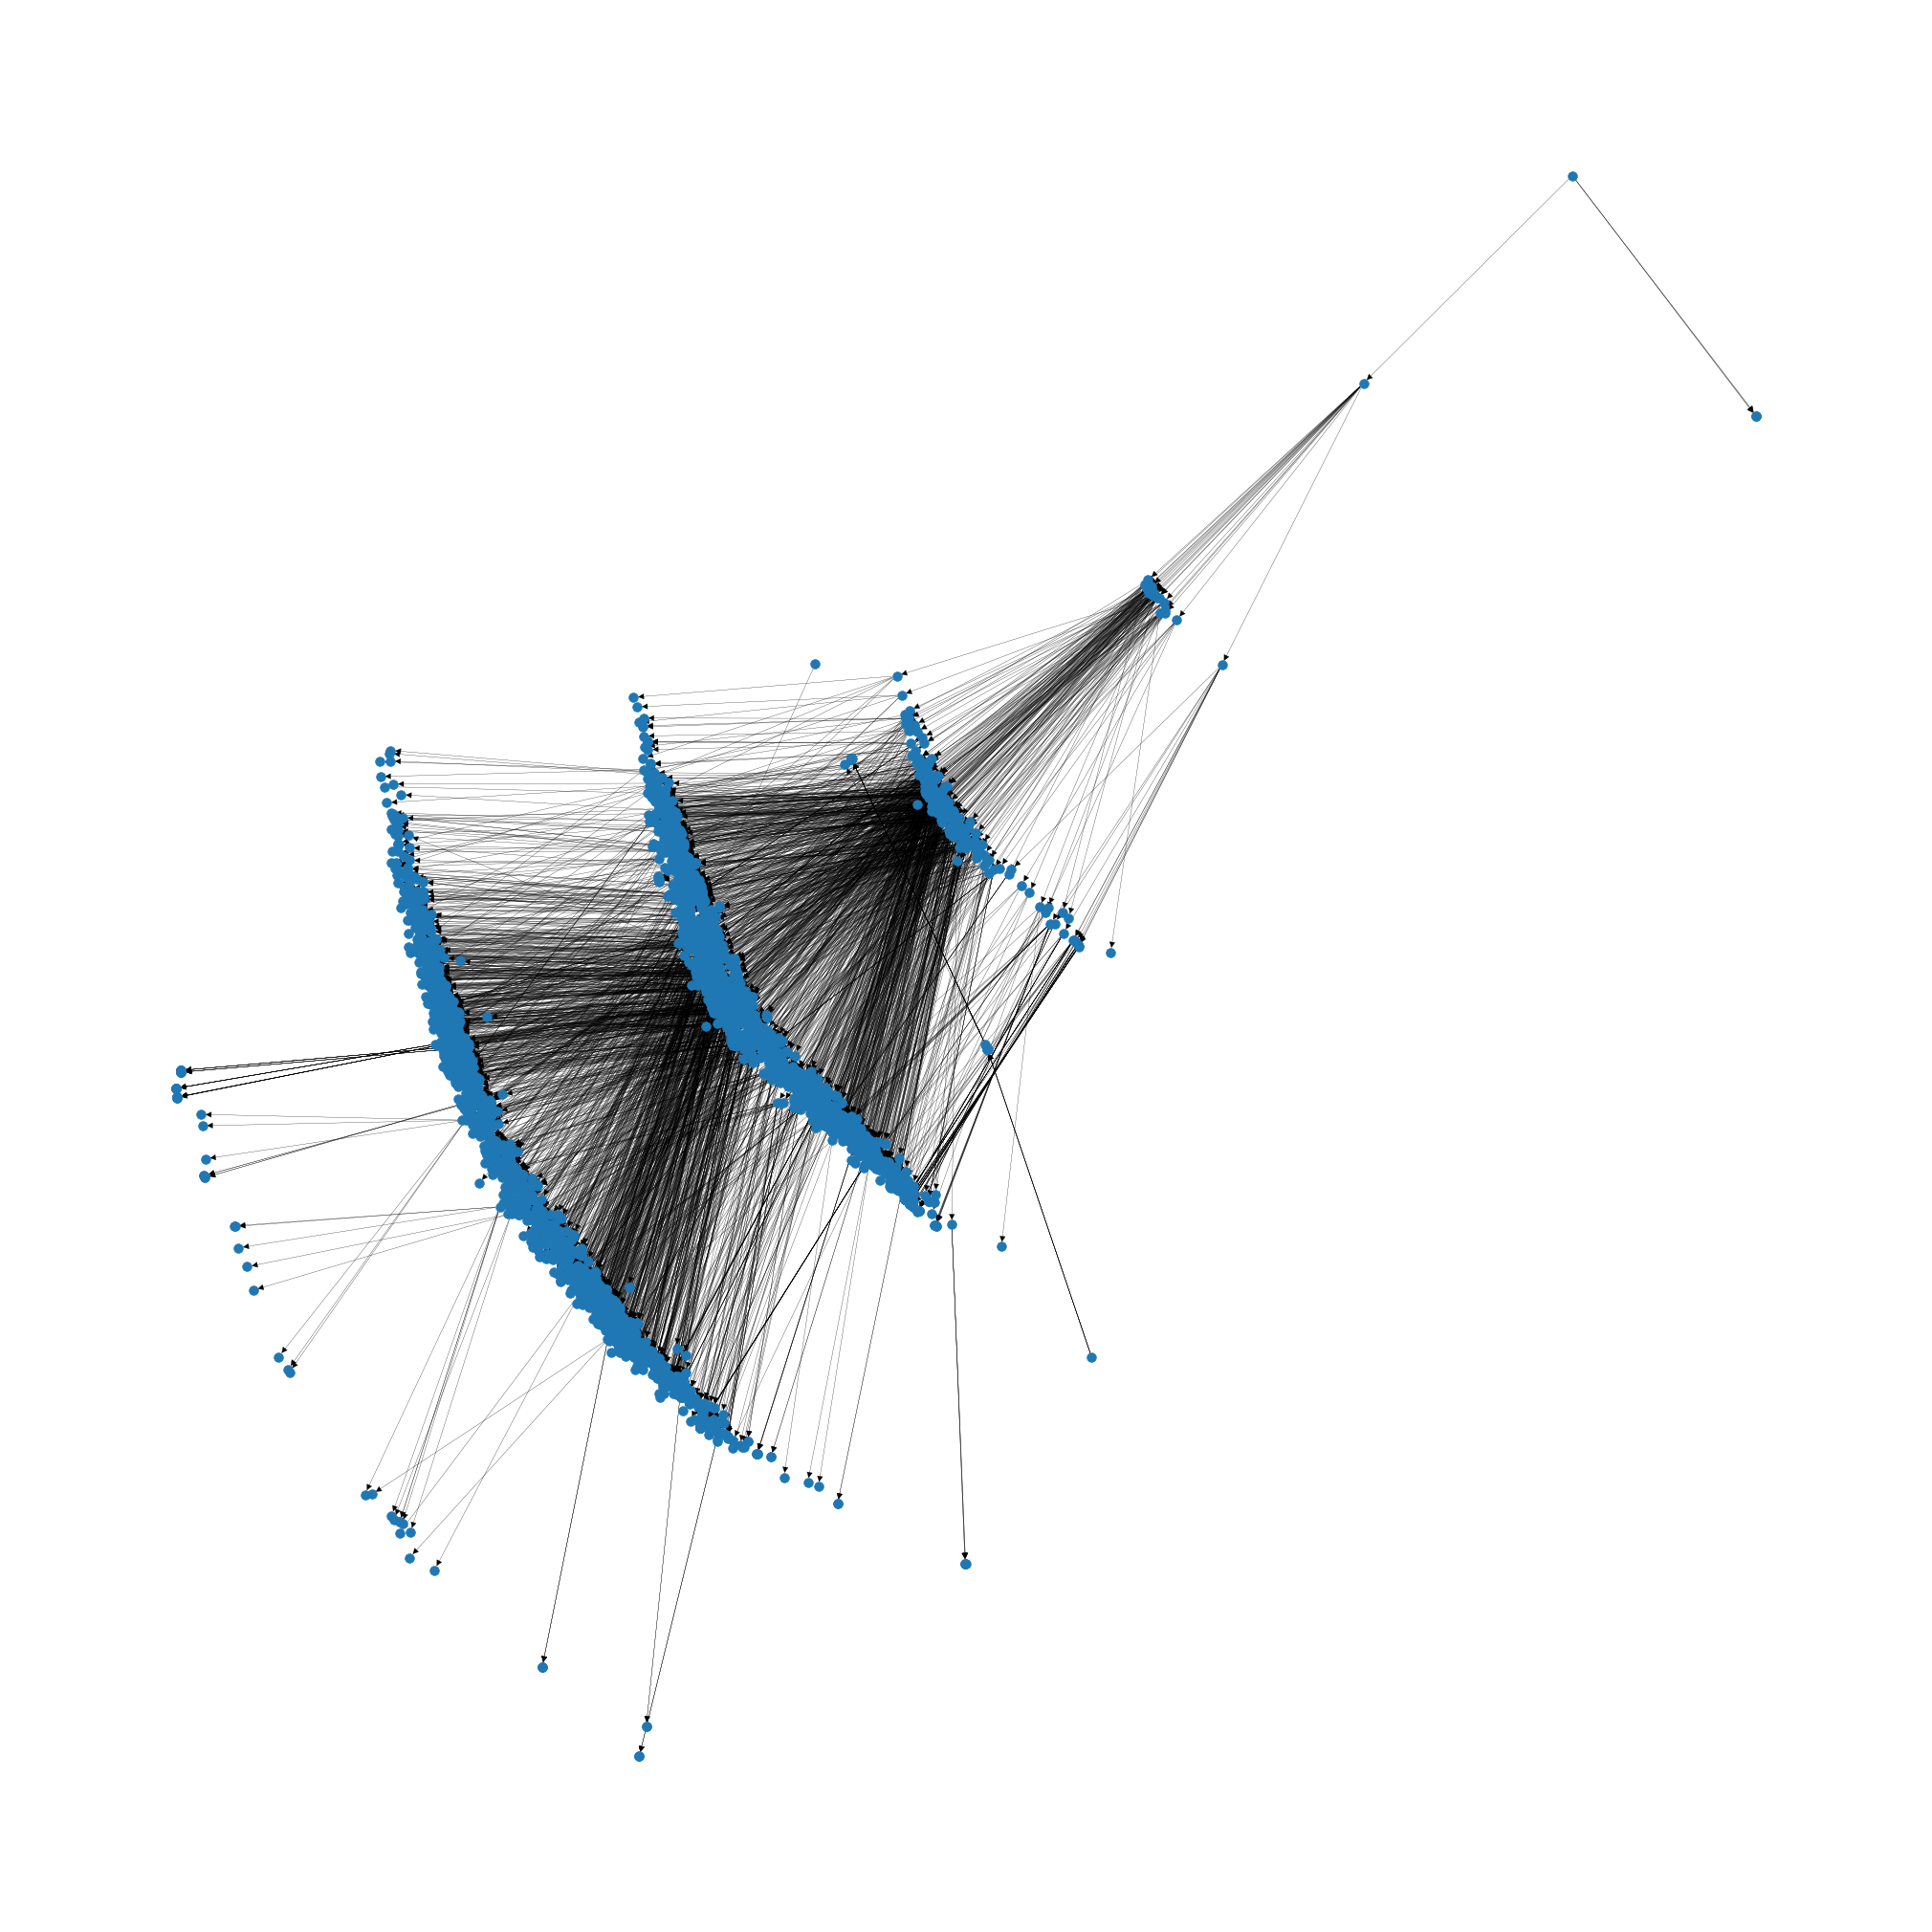

In [8]:
plt.figure(figsize=(20, 20))

nx.draw(category_graph, pos=pos, width=0.2, linewidths=0.4, node_size=50)

На визуализации наблюдаем несколько категорий товаров, которые не связаны с корнем дерева (id = 0).

Восстановим путь для каждой категории каталога в файле category_tree ('root'), а также добавим новый признак ('kind'), характеризующий каждый id как leaf или node.

In [9]:
category_tree['root'] = None
category_tree['kind'] = None

parents_list = category_tree['parent_id'].unique().tolist()

for index, row in category_tree.iterrows():
        category_id = row['id']
        if nx.has_path(category_graph, 0, category_id):
                path = nx.shortest_path(category_graph, 0, category_id)
        else:
                path = list()
                path.append(category_id)
                while category_id in category_tree['id'].unique().tolist():
                        category_id = category_tree[category_tree['id'] == category_id].iloc[0, 2]
                        path.append(category_id)
                path = path[::-1]
        category_tree.at[index, 'root'] = path
        if row['id'] not in parents_list:
                category_tree.at[index, 'kind'] = 'Leaf'
        else:
                category_tree.at[index, 'kind'] = 'Node'


In [10]:
category_tree.head(10)

,id,title,parent_id,root,kind
0,1,Все категории,0,"[0, 1]",Node
1,114,Урбеч,1913,"[0, 1, 1821, 1913, 114]",Leaf
2,115,Варенье и джемы,328,"[0, 1, 1821, 328, 115]",Leaf
3,128,Сухие завтраки,2475,"[0, 1, 1821, 2475, 128]",Leaf
4,131,Масла,2475,"[0, 1, 1821, 2475, 131]",Leaf
5,132,Супы,2475,"[0, 1, 1821, 2475, 132]",Leaf
6,133,Соусы,2475,"[0, 1, 1821, 2475, 133]",Leaf
7,134,Приправы,14283,"[0, 1, 1821, 14283, 134]",Leaf
8,135,"Сахар, соль",2475,"[0, 1, 1821, 2475, 135]",Leaf
9,136,Мука,2475,"[0, 1, 1821, 2475, 136]",Leaf


Исследуем train датасет.

In [11]:
train_df.head()

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,category_id
0,1267423,Muhle Manikure Песочные колпачки для педикюра ...,Muhle Manikure Колпачок песочный шлифовальный ...,None,0.000000,0,2693
1,128833,"Sony Xperia L1 Защитное стекло 2,5D",None,None,4.666667,9,13408
2,569924,"Конверт для денег Прекрасная роза, 16,5 х 8 см","Конверт для денег «Прекрасная роза», 16,5 × 8 см",None,5.000000,6,11790
3,1264824,Серьги,None,None,0.000000,0,14076
4,1339052,Наклейки на унитаз для туалета на крышку бачок...,"Водостойкая, интересная наклейка на унитаз раз...",None,0.000000,0,12401


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283452 entries, 0 to 283451
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          283452 non-null  int64  
 1   title                       283452 non-null  object 
 2   short_description           133130 non-null  object 
 3   name_value_characteristics  50360 non-null   object 
 4   rating                      283452 non-null  float64
 5   feedback_quantity           283452 non-null  int64  
 6   category_id                 283452 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 15.1+ MB


Проверим, нет ли в тренировочном датасете аномальных карточек товаров, представленных нелистовой категорией каталога

In [13]:
train_ids_set = set(train_df['category_id'].unique())
nodes_category_ids_set = set(category_tree[category_tree['kind'] == 'Node']['id'].unique())
check_set = train_ids_set.intersection(nodes_category_ids_set)
if check_set:
        print(f'Количество карточек из датасета, представленных промежуточными категориями: {len(check_set)}')
else:
        print('Все карточки из датасета представлены листьями каталога, но не промежуточными категориями')

Все карточки из датасета представлены листьями каталога, но не промежуточными категориями


In [14]:
train_df.duplicated().sum()

0

In [15]:
nltk.download('stopwords')
nltk.download('punkt')
stopwords_rus = stopwords.words('russian')
stopwords_eng = stopwords.words('english')
stopwords_list = stopwords_rus + stopwords_eng

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\m4x18\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\m4x18\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
def first_n_words(text: str, n: int): # returns first n words of the string
        tokens = text.split()
        return ' '.join(tokens[:n])

def lemmatization_func(text: str): # make lemmatization of str using the pymorphy2.MorphAnalyzer()
        morph_analyzer = pymorphy2.MorphAnalyzer()
        words = text.split()
        result = []
        for word in words:
                p = morph_analyzer.parse(word)[0]
                result.append(p.normal_form)
        return ' '.join(result)

def get_preprocessed_df(df: pd.DataFrame): # make necessary preprocessing of the dataframe
        df['short_description'].fillna('', inplace=True)
        df['name_value_characteristics'].fillna('', inplace=True)
        df.drop(['rating', 'feedback_quantity'], axis=1, inplace=True)

        df['description'] = df['title'] + ' ' + df['short_description'] + ' ' + df['name_value_characteristics']
        df.drop(['title', 'short_description', 'name_value_characteristics'], axis=1, inplace=True)

        df['description'] = df['description'].apply(lambda x: ' '.join([word for word in simple_preprocess(x, min_len=3) if not word in stopwords_list]))

        df['first_title_words'] = df['description'].apply(lambda x: first_n_words(x, 3))
        df['description'] = df['description'] + ' ' + df['first_title_words']
        df.drop(['first_title_words'], axis=1, inplace=True)

        # for index, row in tqdm(df.iterrows(), total=283453):
        #         text = row['description']
        #         lemmatized_text = lemmatization_func(text)
        #         df.at[index, 'description'] = lemmatized_text
        return df

def get_prepared_df_for_fasttext(df: pd.DataFrame, file_name: str): # returns filename and dataframe ready for fasttext training process as per fasttext requirements
        train_for_model = df.copy()
        train_for_model.drop(columns='id', inplace=True)
        train_for_model.loc[:, 'category_id'] = train_for_model.loc[:, 'category_id'].apply(lambda x: '__label__' + str(x))
        train_for_model.to_csv(file_name, index=False, sep=' ', header=None, quoting = csv.QUOTE_NONE, quotechar = "", escapechar = " ")
        return file_name, train_for_model

def f1_score(model, val_data): # calculate f1_score based on precision and recall received from fasttext's test method
        _, precision, recall = model.test(val_data)
        f1 = (2*precision*recall) / (precision+recall)
        return f1

def get_params(model): # returns all hyperparameters of fasttext model
        args_obj = model.f.getArgs()
        params_dict = dict()
        for hparam in dir(args_obj):
                if not hparam.startswith('__'):
                        # if hparam in ['lr', 'dim', 'ws', 'epoch', 'neg', 'wordNgrams']:
                        params_dict[hparam] = getattr(args_obj, hparam)
        return params_dict

def gridsearch_fasttext(params: dict, train_data, val_data): # gridsearch function for finding out best hyperparameters for fasttext model
        result_dict = dict()
        result_dict['parameters'] = list()
        result_dict['score'] = list()
        for p in ParameterGrid(params):
                model = fasttext.train_supervised(train_data, **p)
                key = tuple(p.items())
                score = f1_score(model, val_data)
                result_dict['parameters'].append(key)
                result_dict['score'].append(score)
        result_df = pd.DataFrame.from_dict(result_dict)
        return result_df

def hf1_score(model, val_df): # calculates hierarchical f1_score required by task description
        check_df = val_df.copy()
        check_df['category_id'] = check_df['category_id'].apply(lambda x: x[9:]).astype('int')
        check_df['predicted_id'] = check_df['description'].apply(lambda x: int(model.predict(x)[0][0][9:]))

        y_true = check_df['category_id'].tolist()
        y_pred = check_df['predicted_id'].tolist()

        if len(y_true) != len(y_pred):
                return None
        Ti = 0
        Pi = 0
        Ti_u_Pi = 0
        for true, pred in zip(y_true, y_pred):
                set_Ti = set(category_tree[category_tree['id'] == true].iat[0,3])
                set_Pi = set(category_tree[category_tree['id'] == pred].iat[0,3])
                intersection_set = set_Ti.intersection(set_Pi)
                Ti += len(set_Ti)
                Pi += len(set_Pi)
                Ti_u_Pi += len(intersection_set)
        hP = Ti_u_Pi / Pi
        hR = Ti_u_Pi / Ti
        return 2 * hP * hR / (hP + hR)


In [17]:
train_df.head()

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,category_id
0,1267423,Muhle Manikure Песочные колпачки для педикюра ...,Muhle Manikure Колпачок песочный шлифовальный ...,None,0.000000,0,2693
1,128833,"Sony Xperia L1 Защитное стекло 2,5D",None,None,4.666667,9,13408
2,569924,"Конверт для денег Прекрасная роза, 16,5 х 8 см","Конверт для денег «Прекрасная роза», 16,5 × 8 см",None,5.000000,6,11790
3,1264824,Серьги,None,None,0.000000,0,14076
4,1339052,Наклейки на унитаз для туалета на крышку бачок...,"Водостойкая, интересная наклейка на унитаз раз...",None,0.000000,0,12401


In [18]:
%%time
train_df = get_preprocessed_df(train_df)

CPU times: total: 13.2 s
Wall time: 13.5 s


In [19]:
train_df.head()

,id,category_id,description
0,1267423,2693,muhle manikure песочные колпачки педикюра сред...
1,128833,13408,sony xperia защитное стекло sony xperia защитное
2,569924,11790,конверт денег прекрасная роза конверт денег пр...
3,1264824,14076,серьги серьги
4,1339052,12401,наклейки унитаз туалета крышку бачок дверь ван...


In [20]:
train = train_df.sample(frac=0.9)
val = train_df.drop(train.index)

In [21]:
_, train = get_prepared_df_for_fasttext(train, 'train.txt')

In [22]:
_, val = get_prepared_df_for_fasttext(val, 'val.txt')

In [23]:
train.head()

,category_id,description
246876,__label__12813,брошь балерина брошь балерина
263704,__label__13495,светодиодная лампа ретро стиль гирлянда лампоч...
149241,__label__14434,lemontay масляные духи женские wigdan вигдан м...
236828,__label__12454,сильный магнит гель лаков кошачий глаз сильный...
113486,__label__13061,серьги серьги серьги серьги
...,...,...
191694,__label__12548,праздничное пышное платье поясом подкладом тка...
117211,__label__12595,палантин универсальный вискоза размер цветы ли...
147603,__label__13310,патч корд geplink atcom сетевой интернетный ка...
185889,__label__12479,сумка шоппер авоська экосумка жираф малыш сумк...


За все время экспериментов с autotune, gridsearch и подбором параметров были получены следующие результаты:

model(autotune - 5 min): f1_score = 0.8335, hf1_score = 0.9298
model(autotune - 8hours): f1_score = 0.8515, hf1_score = 0.9318
model(lr=0.35, wordNgrams = 3, autotune - 10 min): f1_score = 0.8589, hf1_score = 0.9369
model_gridsearch(lr=0.5, dim=100, epoch=20, wordNgrams=3): f1_score = 0.8622, hf1_score = 0.9456

в качестве финальной модели будем использовать параметры:

lr=0.5,
dim=100,
epoch=20,
wordNgrams=3

In [24]:
%%time
fasttext_model = fasttext.train_supervised('train.txt', lr=0.5, dim=100, epoch=20, wordNgrams=3, verbose=3)

CPU times: total: 1h 5min 30s
Wall time: 6min 35s


In [25]:
f1_score(fasttext_model,'val.txt')

0.8622684776856588

In [26]:
hf1_score(fasttext_model, val)

0.9455863483193226

Готовим весь train датасет и обучаем на нем финальный вариант модели fasttext.

In [28]:
_, train_full_df = get_prepared_df_for_fasttext(train_df, 'train_full.txt')

In [29]:
%%time
fasttext_model = fasttext.train_supervised('train_full.txt', lr=0.5, dim=100, epoch=20, wordNgrams=3, verbose=3)

CPU times: total: 1h 11min 51s
Wall time: 7min 4s


In [30]:
f1_score(fasttext_model, 'val.txt')

0.9844769800670312

In [31]:
hf1_score(fasttext_model, val)

0.993474949322906

Готовим test датасет и предсказываем категории с помощью модели обученной на train_full датасете.

In [32]:
test_df.head()

,id,title,short_description,name_value_characteristics,rating,feedback_quantity
0,1070974,Браслет из натуральных камней LOTUS,None,None,0.000000,0
1,450413,Fusion Life - Шампунь для сухих и окрашенных в...,None,None,4.333333,6
2,126857,"Микрофон для ПК jack 3,5мм всенаправленный","универсальный 3,5 мм микрофон запишет ваш звук",None,3.708333,24
3,1577569,Серьги гвоздики сердце,Серьги гвоздики сердце,None,0.000000,0
4,869328,"Чёрно-красная стильная брошь ""Тюльпаны"" из акр...",Стильная и яркая брошь ручной работы! Великоле...,None,0.000000,0


In [33]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70864 entries, 0 to 70863
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          70864 non-null  int64  
 1   title                       70864 non-null  object 
 2   short_description           33346 non-null  object 
 3   name_value_characteristics  12576 non-null  object 
 4   rating                      70864 non-null  float64
 5   feedback_quantity           70864 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 3.2+ MB


In [34]:
%%time
test_df = get_preprocessed_df(test_df)

test_df['predicted_id'] = test_df['description'].apply(lambda x: int(fasttext_model.predict(x)[0][0][9:]))
test_df.drop(['description'], axis=1, inplace=True)

CPU times: total: 10.8 s
Wall time: 11 s


In [35]:
test_df.head()

,id,predicted_id
0,1070974,11574
1,450413,11878
2,126857,13299
3,1577569,13061
4,869328,12813


In [36]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70864 entries, 0 to 70863
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   id            70864 non-null  int64
 1   predicted_id  70864 non-null  int64
dtypes: int64(2)
memory usage: 1.1 MB


In [37]:
test_df.to_parquet('result.parquet')